In [1]:
import json
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [23]:
df = pd.read_csv('torbens_tolle_timeseries.csv')
df['created_at'] = pd.to_datetime(df.created_at, utc=False)

In [3]:
# model training
def trainLM(df, mkplot=True):
    X = np.array(df.loc[:, df.columns != 'count'])
    y = df['count']
    model = LinearRegression().fit(X, y)
    eval_df = df[['count']].copy()
    eval_df['pred'] = model.predict(X)
    print('Koeffizienten: ', model.coef_,' Intercept: ',model.intercept_)
    print("Mean Squared Error: ",mean_squared_error(eval_df['count'], eval_df.pred))
    print("R2_Score: ", r2_score(eval_df['count'], eval_df.pred))
    print('Number of rows: ',len(df))
    if mkplot:
        eval_df.iloc[1:100].plot(figsize=(15,5))
        eval_df.iloc[1:1000].plot(figsize=(15,5))
        eval_df.plot(figsize=(15,5))
    return eval_df, model

In [5]:
# Compute next timestamps for hourly pred
def next_nh_timestamps(timeseries, n):
    """ Input: timeseries in 1 h chunks, n -> Number of next timestemps"""
    forecast = []
    year = timeseries.tail(1).index[0].year
    month = timeseries.tail(1).index[0].month
    day = timeseries.tail(1).index[0].day
    hour = timeseries.tail(1).index[0].hour
    minute = timeseries.tail(1).index[0].minute
    for el in range(n):
        hour +=1
        if hour == 24:
            hour =0
            day += 1
            if day == 31:
                day = 1
                month += 1
                if month == 13:
                    month = 1
                    year += 1
        forecast.append(pd.Timestamp(year=year, month=month, day=day, hour=hour, minute=minute))
    return forecast

In [6]:
# Compute next timestamps
def next_n_timestamps(timeseries, n):
    """ Input: timeseries in 5 min chunks, n -> Number of next timestemps"""
    forecast = []
    year = timeseries.tail(1).index[0].year
    month = timeseries.tail(1).index[0].month
    day = timeseries.tail(1).index[0].day
    hour = timeseries.tail(1).index[0].hour
    minute = timeseries.tail(1).index[0].minute
    for el in range(n):
        minute +=5
        if minute == 60:
            minute = 0
            hour +=1
            if hour == 24:
                hour =0
                day += 1
                if day == 31:
                    day = 1
                    month += 1
                    if month == 13:
                        month = 1
                        year += 1
        forecast.append(pd.Timestamp(year=year, month=month, day=day, hour=hour, minute=minute, second = 0, microsecond = 0))
    return forecast

In [7]:
# Needed help function because we need to loop several times over this to get all the t1-5 shifts done
def perform_shifts(df):
    df['t-1'] = df['count'].shift(1)
    df['t-2'] = df['count'].shift(2)
    df['t-3'] = df['count'].shift(3)
    df['t-4'] = df['count'].shift(4)
    df['t-5'] = df['count'].shift(5)
    return df

In [12]:
# complete pipeline
def timeseries_analysis(df, party=False):
    """Function to perform forecast for next day & week
       Takes oroginal DF and party = Partyname if forecast for specific party is required
    """
    if party:
        ts = df.groupby([pd.Grouper(key="created_at", freq="5min"), pd.Grouper('party_ref')]).count()[['user.id']].reset_index().rename(columns={'author_party':'Party','user.id':'count'}).set_index('created_at') 
        ts = ts[ts['party_ref']=='Grüne'].drop('party_ref',axis=1)
    else:
        ts = df.groupby(pd.Grouper(key="created_at", freq="5min")).count()[['user.id']].rename(columns={'user.id':'count'})
    
    # Add Timestamps for the forecast period: next 24 hours
    new = next_n_timestamps(ts, 288)
    countfake = np.full((len(new),1), np.nan) 
    df_1d = pd.DataFrame(countfake, index =new, columns=['count'])
    df_1d.index = df_1d.index.astype('datetime64[ns, UTC]')
    ts = pd.concat([ts,df_1d])
    
    # Feature Engineering
    ts['month'] = ts['count'].index.month
    ts['week'] = ts['count'].index.week
    ts['hour'] = ts['count'].index.hour
    ts['minute'] = ts['count'].index.minute
    #days to election
    ts['days_to_election'] = (pd.Timestamp(year=2017,month=9,day=24, tz= 'UTC')-ts.index).days
    # Add mean monthly tweets to remove monthly fluctuation
    ts['month_avg'] = ts[['count']].groupby([ts.index.month]).transform('mean')
    # Add mean weekly tweets to remove weekly fluctuation
    ts['week_avg'] = ts[['count']].groupby([ts.index.week]).transform('mean')
    # Add mean hourly tweets to remove hourly fluctuation
    ts['hour_avg'] = ts[['count']].groupby([ts.index.hour]).transform('mean')
    # Integrate Day as binary
    ts['day'] = 0
    ts.loc[(ts.index.hour > 6) & (ts.index.hour<=18),'day'] = 1
    # Integrate Workday as binary
    ts['Workday'] = 1
    ts.loc[(ts.index.weekday == 5 )|(ts.index.weekday == 6),'Workday'] = 0
    # Integrate AR for 24 h ago -> look 24*12 steps back as data is stored in chunks of 5 min
    ts['t-288'] = ts['count'].shift(288)
    # Integrate AR for 1 week ago -> look 24*12*7 steps back as data is stored in chunks of 5 min
    if ts.shape[0] > 2016:
        ts['t-2016'] = ts['count'].shift(2016)
    else:
        pass
    # Integrate AR of past 5 Sessions -> no theoretical reasoning for usage, decreases MSE by roughly 10 percent, no decrease in r2
    ts['t-1'] = ts['count'].shift(1)
    ts['t-2'] = ts['t-1'].shift(1)
    ts['t-3'] = ts['t-2'].shift(1)
    ts['t-4'] = ts['t-3'].shift(1)
    ts['t-5'] = ts['t-4'].shift(1)
    ts['time'] = (ts.index - ts.index[0]).days
    # save a worker version without dropped columns
    worker_df = ts.copy()
    # drop na as first x rows are not filled due to shift operation
    ts.dropna(inplace=True)
    
    # train model
    eva,model =trainLM(ts)
    
    # to reduce complexity only work on tail of df
    timeseries_worker = worker_df.iloc[-600:]

    # Compute shift operations for forecast
    for el in range(288):
        # Insert predicting into "count" column
        timeseries_worker.iloc[-288+el, timeseries_worker.columns.get_loc('count')] = model.predict(np.array(timeseries_worker.loc[:, timeseries_worker.columns != 'count'].iloc[-288+el:].iloc[0]).reshape(1,-1))[0].round(0)
        # perform shifting operations again 
        timeseries_worker = perform_shifts(timeseries_worker)
    
    # Plot Forecast
    last_d = timeseries_worker[['count']].iloc[-576:-288].plot(figsize=(15,5), title = "last_d")
    forecast = timeseries_worker[['count']].iloc[-288:].plot(figsize=(15,5), title= f'24 h forecast for {party}')
    
    return last_d, forecast, eva, timeseries_worker.iloc[-50:]

In [11]:
# complete pipeline for 1h predictions
def timeseries_analysis_h(df, party=False):
    """Function to perform forecast for next day & week
       Takes oroginal DF and party = Partyname if forecast for specific party is required
    """
    if party:
        ts = df.groupby([pd.Grouper(key="created_at", freq="1h"), pd.Grouper('party_ref')]).count()[['user.id']].reset_index().rename(columns={'author_party':'Party','user.id':'count'}).set_index('created_at') 
        ts = ts[ts['party_ref']=='Grüne'].drop('party_ref',axis=1)
    else:
        ts = df.groupby(pd.Grouper(key="created_at", freq="1h")).count()[['user.id']].rename(columns={'user.id':'count'})
    
    # Add Timestamps for the forecast period: next 24 hours
    new = next_nh_timestamps(ts, 24)
    countfake = np.full((len(new),1), np.nan) 
    df_1d = pd.DataFrame(countfake, index =new, columns=['count'])
    df_1d.index = df_1d.index.astype('datetime64[ns, UTC]')
    ts = pd.concat([ts,df_1d])
    
    # Feature Engineering
    ts['month'] = ts['count'].index.month
    ts['week'] = ts['count'].index.week
    ts['hour'] = ts['count'].index.hour
    ts['minute'] = ts['count'].index.minute
    #days to election
    ts['days_to_election'] = (pd.Timestamp(year=2017,month=9,day=24, tz= 'UTC')-ts.index).days
    # Add mean monthly tweets to remove monthly fluctuation
    ts['month_avg'] = ts[['count']].groupby([ts.index.month]).transform('mean')
    # Add mean weekly tweets to remove weekly fluctuation
    ts['week_avg'] = ts[['count']].groupby([ts.index.week]).transform('mean')
    # Add mean hourly tweets to remove hourly fluctuation
    ts['hour_avg'] = ts[['count']].groupby([ts.index.hour]).transform('mean')
    # Integrate Day as binary
    ts['day'] = 0
    ts.loc[(ts.index.hour > 6) & (ts.index.hour<=18),'day'] = 1
    # Integrate Workday as binary
    ts['Workday'] = 1
    ts.loc[(ts.index.weekday == 5 )|(ts.index.weekday == 6),'Workday'] = 0
    # Integrate AR for 24 h ago -> look 24 steps back as data is stored in chunks of 1 h
    ts['t-24'] = ts['count'].shift(24)
    # Integrate AR for 1 week ago -> look 24*7 steps back as data is stored in chunks of 1 h
    if ts.shape[0] > 168:
        ts['t-168'] = ts['count'].shift(168)
    else:
        pass
    # Integrate AR of past 5 Sessions -> no theoretical reasoning for usage, decreases MSE by roughly 10 percent, no decrease in r2
    ts['t-1'] = ts['count'].shift(1)
    ts['t-2'] = ts['t-1'].shift(1)
    ts['t-3'] = ts['t-2'].shift(1)
    ts['t-4'] = ts['t-3'].shift(1)
    ts['t-5'] = ts['t-4'].shift(1)
    ts['time'] = (ts.index - ts.index[0]).days
    # save a worker version without dropped columns
    worker_df = ts.copy()
    # drop na as first x rows are not filled due to shift operation
    ts.dropna(inplace=True)
    
    # train model
    eva,model =trainLM(ts)
    
    # to reduce complexity only work on tail of df
    timeseries_worker = worker_df.iloc[-240:]

    # Compute shift operations for forecast
    for el in range(24):
        # Insert predicting into "count" column
        timeseries_worker.iloc[-24+el, timeseries_worker.columns.get_loc('count')] = 0 if model.predict(np.array(timeseries_worker.loc[:, timeseries_worker.columns != 'count'].iloc[-24+el:].iloc[0]).reshape(1,-1))[0].round(0)<0 else model.predict(np.array(timeseries_worker.loc[:, timeseries_worker.columns != 'count'].iloc[-24+el:].iloc[0]).reshape(1,-1))[0].round(0)
        # perform shifting operations again 
        timeseries_worker = perform_shifts(timeseries_worker)
    
    # Plot Forecast
    last_w = timeseries_worker[['count']].iloc[-216:-192].plot(figsize=(15,5), title= 'last_w')
    last_d = timeseries_worker[['count']].iloc[-48:-24].plot(figsize=(15,5), title = 'last_d')
    forecast = timeseries_worker[['count']].iloc[-24:].plot(figsize=(15,5), title = f'24 h forecast for {party}')
    
    return last_w, last_d, forecast, eva, timeseries_worker.iloc[-25:]

Koeffizienten:  [-6.48825740e+00 -1.57900575e+01 -1.26240725e-01 -2.03392858e-13
 -9.20392501e+00  3.13425625e+00  5.27858161e-01  1.08660601e+00
 -4.47829819e+00  1.21906543e+01  3.98719903e-02  6.86631069e-03
  2.60806982e-01 -1.94648638e-02  1.10435107e-01  1.76922695e-02
  2.50518211e-02 -6.42411916e+00]  Intercept:  1307.7994866947577
Mean Squared Error:  968.4081819816716
R2_Score:  0.3642227342978246
Number of rows:  375


(<AxesSubplot:title={'center':'last_w'}>,
 <AxesSubplot:title={'center':'last_d'}>,
 <AxesSubplot:title={'center':'24 h forecast for Grüne'}>,
                            count       pred
 2017-06-15 19:00:00+00:00   35.0  27.689169
 2017-06-15 20:00:00+00:00    1.0  13.182334
 2017-06-15 22:00:00+00:00    4.0   2.191317
 2017-06-15 23:00:00+00:00    5.0  -3.109348
 2017-06-16 00:00:00+00:00    1.0 -12.921379
 ...                          ...        ...
 2017-07-18 06:00:00+00:00    8.0  40.489496
 2017-07-18 07:00:00+00:00   52.0  57.142327
 2017-07-18 08:00:00+00:00   11.0  65.495899
 2017-07-18 10:00:00+00:00   73.0  42.483479
 2017-07-18 11:00:00+00:00   88.0  68.115432
 
 [375 rows x 2 columns],
                            count  month  week  hour  minute  days_to_election  \
 2017-07-18 11:00:00+00:00   88.0      7    29    11       0                67   
 2017-07-18 12:00:00+00:00   56.0      7    29    12       0                67   
 2017-07-18 13:00:00+00:00   50.0      7    

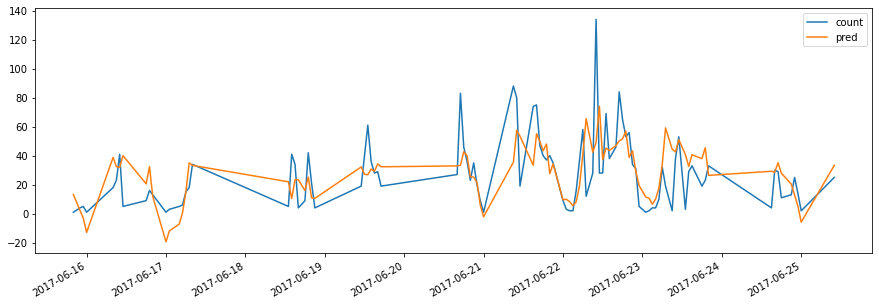

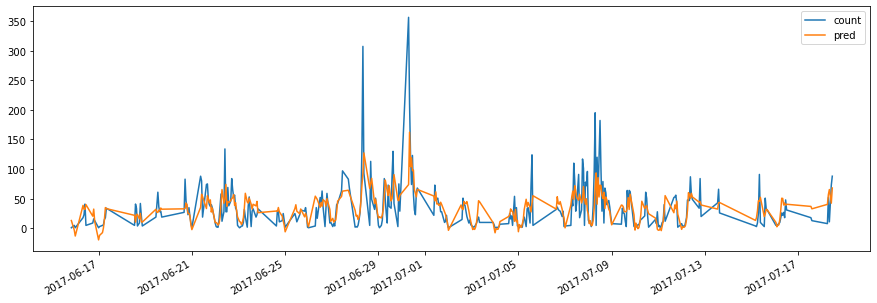

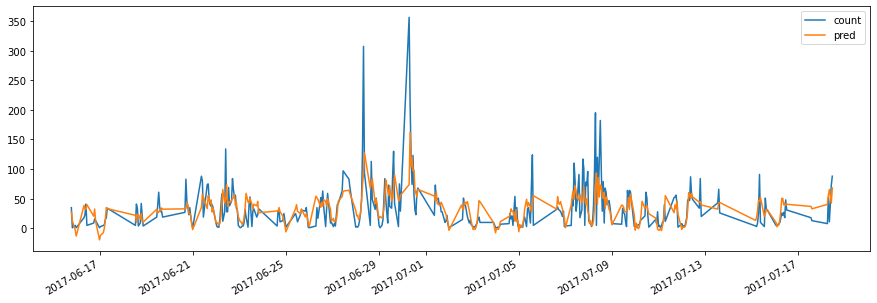

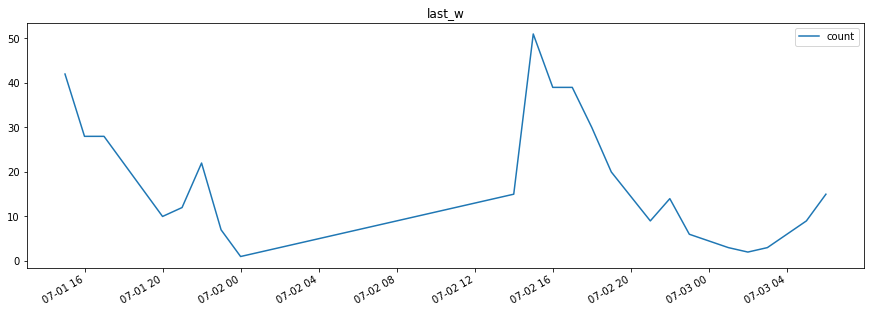

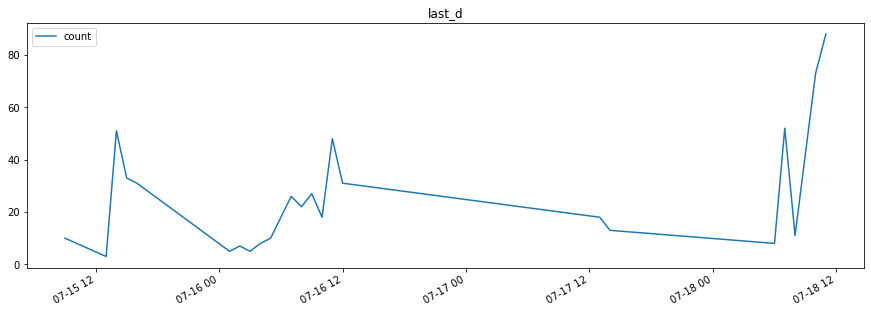

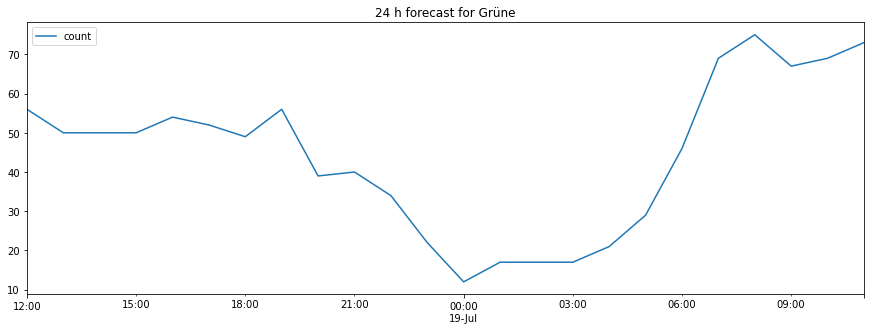

In [15]:
timeseries_analysis_h(df,party='Grüne')

### Try Arma impementation

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def evalARMA(model, df, mkplot=True):
    eval_df = df[['count']].copy()
    eval_df['pred'] = model.predict()
    print("Mean Squared Error: ",mean_squared_error(eval_df['count'], eval_df.pred))
    if mkplot:
        eval_df.iloc[1:100].plot(figsize=(15,5))
        eval_df.plot(figsize=(15,5))

Mean Squared Error:  93.99133193548779


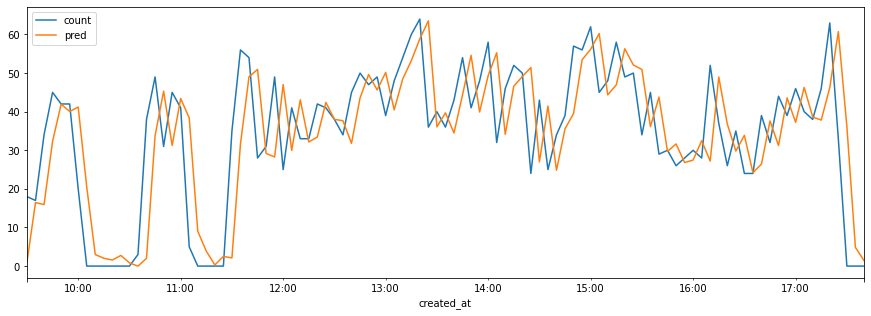

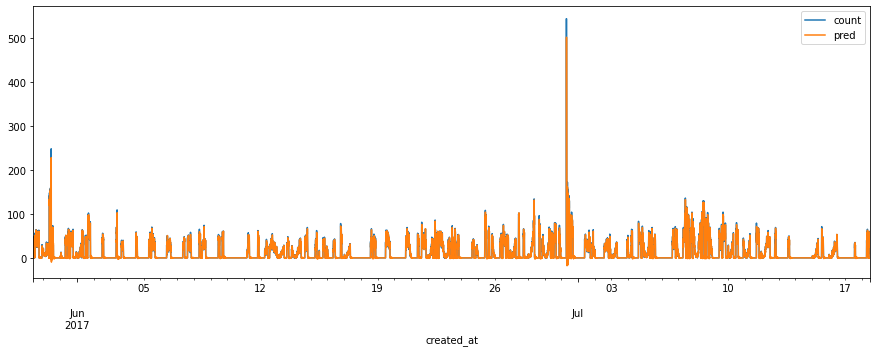

In [17]:
dfa = df.groupby(pd.Grouper(key="created_at", freq="5min")).count()[['user.id']].rename(columns={'user.id':'count'})
arma = SARIMAX(dfa[['count']], order=(5,1,0), seasonal_order=(4,0,0,12)  ).fit() # ARMA handles univariate time series only and does its own time-shifting
evalARMA(arma, dfa)

In [21]:
df['b'].isna().any()

False

In [22]:
df = pd.DataFrame({'a':[np.nan,1],'b':[2,1]})
if df['b'].isna().any():
    print ('Nan found')
else:
    print ('All gud')

All gud


In [31]:
ts = df.groupby(pd.Grouper(key="created_at", freq="5min")).count()[['user.id']].rename(columns={'user.id':'count'})

In [32]:
ts.shape[0]

14431